In [164]:
# pandas for data manipulation and analysis
import pandas as pd
# numpy to manipulate multi-dimensional arrays and matrices
import numpy as np
# re - regex to provides regular expression matching operations
import re
# the OS module in Python provides a way of using operating system dependent functionality
import os
# the requests module allows you to send HTTP requests using Python
import requests
# python-dotenv to read the key-value pair from . env file and adds them to environment variable.
from dotenv import load_dotenv
#Beautiful Soup is a Python library for pulling data out of HTML and XML files
from bs4 import BeautifulSoup
# The selenium package is used to automate web browser interaction from Python
from selenium import webdriver
# to simplify management of binary drivers for different browsers
#import chromedriver_binary 
from webdriver_manager.chrome import ChromeDriverManager
import matplotlib.pyplot as plt

def import_dataset():
    df = pd.read_csv('inputs/datasets_Nba_Players.csv', encoding = 'latin-1')
    df = df.rename({'collage':'college'}, axis=1)
    return df


def save_api_key_in_env():
    load_dotenv()
    apikey = os.getenv("APIKEY")
    return apikey


def url_web_api():
    # enviar una request. Si sale un numero que empieza con 2 todo bien, 
    # o si no ver los errores de los gatos a ver que dicen!
    url = 'http://api.probasketballapi.com/player'
    res = requests.post(url)
    return url


def player_name():
    first_name = input('Insert the name of an NBA player')
    last_name = input('Insert the last_name of an NBA player')
    return first_name, last_name


def call_player(player_name):
    try:
        query = {'api_key': f'{apikey}', 'first_name':f'{player_name[0]}', 'last_name':f'{player_name[1]}'}
        r = requests.post(url, data=query)
        player_api =r.json()[0]
        table_api = pd.DataFrame(player_api, index=[0])
        return table_api.head()
    except:
        print('Player not in database. Try another one')
        return call_player(input('Insert new player'))

def merge_info_api(player_name, player_table):
    query_player = df[(df['Player']==f'{player_name[0]} {player_name[1]}')]
    # Rename the column with the common data
    player_table = player_table.rename({'player_name':'Player'}, axis=1)
    # Merge of the two tables
    query_player_update = pd.merge(query_player, player_table, on='Player', how='outer')
    # Eliminate redundant information
    query_player_update = query_player_update[['Unnamed: 0', 'Player', 'first_name', 'last_name', 
    'born', 'birth_date','birth_city', 'college','height', 'weight','position', 'dk_position']]
    # Result compared to the original data)
    return query_player_update

def getPage(url):
    # This function show a basic way to make a get requests used Selenium
    # First line to to avoid this error:
    # WebDriverException: Message: 'chromedriver' executable needs to be available in the path.
    # driver.execute_script(..) to scroll the page in Selenium untill the bottom
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    #box = driver.find_element_by_xpath('/html/body/main/div[1]/div/div[1]/div[1]/input')
    #box.send_keys('LeBron James')
    html = driver.page_source
    soup = BeautifulSoup(html)
    driver.quit()
    return soup


# different way to scraping the webpabge, using CSS selector or tags
# Ex.1 - just columns name
def scraping_columnas(soup):
    columnas = [table.text.split() for table in soup.select("thead")]
    return columnas
def scraping_lenght(soup):
    # Ex.2 - all value in the table
    lenght = [table.text.split() for table in soup.select("tbody")]
    return lenght
def scraping_row(soup):
    row = [table.text.split() for table in soup.select("tbody > tr")]
    return row
# I use the years variable to store the information of the athlete's years of activity, 
#which is different for each athlete. This way I can create a generic scraping that works for most players


def cleaning_variable(row):
    # clean the variable from unnecessary fields, to facilitate the process of creating dictionaries
    new_row = []
    for x in row:
        if len(x)>1:
            new_row.append(x)
    return new_row


def creacolumnas(columnas, empty_dict):
    # this function allows you to create the keys of each dictionary
    for column in columnas:
        empty_dict[column] = []  


def creafilas(row, numpari, empty_dict, years):
    # this function allows you to fill the data tables
    for i,value in enumerate(empty_dict.keys()):
        for x in range(years):
            try:
                empty_dict[value].append(row[x+(numpari*years)][i])
            except:
                pass


def cleaning_tabla1(columnas, number):
    # an additional procedure for cleaning the keys that will be inserted in each dictionary
    columnas_tabla1 =columnas[0][number::]
    return columnas_tabla1


def create_selenium_player(number):
    soup1 = getPage(f"https://stats.nba.com/player/{number}")
    print(number)
    columnas_player1 = scraping_columnas(soup1)
    lenght_player1 = scraping_lenght(soup1)
    row_player1 = scraping_row(soup1)
    years_player1 = len(lenght_player1[1])
    Traditional_Splits_player1  = dict()
    new_row_player1 = cleaning_variable(row_player1)
    if 'career' in str(number):
        columnas_tabla_player1 = cleaning_tabla1(columnas_player1, 0)
    else:
        columnas_tabla_player1 = cleaning_tabla1(columnas_player1, 1)
    creacolumnas(columnas_tabla_player1, Traditional_Splits_player1 )
    creafilas(new_row_player1, 0, Traditional_Splits_player1 , years_player1)
    table1 = pd.DataFrame(Traditional_Splits_player1)
    return table1


def merge_selenium_table(table):
    # Change the type of each column in float in order to calculate its average of values
    table = table[['GP','MIN','PTS','FGM','FGA','FG%','3PM','3PA','3P%','FTM','FTA','FT%',
        'OREB','DREB','REB','AST','TOV','STL','BLK','PF']].astype(float)
    # The new selenium dataset with the average statistics of the player's entire career
    table_mean_stats = pd.DataFrame(table.mean()).T
    return table_mean_stats


def create_new_columns_to_merge_dataset(players_name, table):
    table['Player'] = f'{players_name[0]} {players_name[1]}'
    return table


def merge_info_selenium(table_before_selenium, table_selenium):
    # Merge of the two tables
    final_table = pd.merge(table_before_selenium, table_selenium, on='Player', how='outer')
    return final_table


def create_final_table_api(name):
    players1_name = name.split()
    players1_table = call_player(players1_name)
    player1_table_api = merge_info_api(players1_name, players1_table)
    return player1_table_api

def create_final_table_selenium(name):
    table_player1 = create_selenium_player(2544)
    return table_player1



df = import_dataset()
apikey = save_api_key_in_env()
url = url_web_api()

In [4]:
name = input('insert name player NBA')
player1_table_api = create_final_table_api(name)
table_player1 = create_final_table_selenium(name)

insert name player NBALeBron James


[WDM] - Current google-chrome version is 81.0.4044
[WDM] - Get LATEST driver version for 81.0.4044


[WDM] - Driver [/home/must4in3/.wdm/drivers/chromedriver/linux64/81.0.4044.138/chromedriver] found in cache


2544


In [5]:
table_player1_selenium = merge_selenium_table(table_player1)
table_player1_selenium['Player'] = f'{name.split()[0]} {name.split()[1]}'
table_player1_final = pd.merge(player1_table_api, table_player1_selenium, on='Player', how='outer')

In [6]:
table_player1

,Year,TEAM,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,2019-20,LAL,60,34.9,25.7,9.8,19.6,49.8,2.2,6.4,...,7.9,10.6,4.0,1.2,0.5,1.8,52.3,42,13,8.1
1,2018-19,LAL,55,35.2,27.4,10.1,19.9,51.0,2.0,5.9,...,8.5,8.3,3.6,1.3,0.6,1.7,52.0,32,8,2.1
2,2017-18,CLE,82,36.9,27.5,10.5,19.3,54.2,1.8,5.0,...,8.6,9.1,4.2,1.4,0.9,1.7,54.1,52,18,1.3
3,2016-17,CLE,74,37.8,26.4,9.9,18.2,54.8,1.7,4.6,...,8.6,8.7,4.1,1.2,0.6,1.8,51.3,42,13,6.5
4,2015-16,CLE,76,35.6,25.3,9.7,18.6,52.0,1.1,3.7,...,7.4,6.8,3.3,1.4,0.6,1.9,47.1,28,3,8.1
5,2014-15,CLE,69,36.1,25.3,9.0,18.5,48.8,1.7,4.9,...,6.0,7.4,3.9,1.6,0.7,2.0,46.5,22,2,7.8
6,2013-14,MIA,77,37.7,27.1,10.0,17.6,56.7,1.5,4.0,...,6.9,6.3,3.5,1.6,0.3,1.6,47.2,12,1,5.3
7,2012-13,MIA,76,37.9,26.8,10.1,17.8,56.5,1.4,3.3,...,8.0,7.3,3.0,1.7,0.9,1.4,52.1,36,4,9.5
8,2011-12,MIA,62,37.5,27.1,10.0,18.9,53.1,0.9,2.4,...,7.9,6.2,3.4,1.9,0.8,1.5,50.6,23,0,7.6
9,2010-11,MIA,79,38.8,26.7,9.6,18.8,51.0,1.2,3.5,...,7.5,7.0,3.6,1.6,0.6,2.1,49.2,31,4,7.8


In [7]:
table_player1_final

,Unnamed: 0,Player,first_name,last_name,born,birth_date,birth_city,college,height,weight,...,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF
0,2944,LeBron James,LeBron,James,1984.0,1984-12-30,Akron,NaN,203.0,113.0,...,7.958824,73.176471,1.194118,6.282353,7.452941,7.435294,3.511765,1.588235,0.741176,1.835294


In [8]:
table_player1.to_csv(r'output/all_stats_player.csv')
table_player1_final.to_csv(r'output/resume_stats_player.csv')

In [9]:
table_player1['Player'] = f'{name.split()[0]} {name.split()[1]}'

In [15]:
table_player1.columns

Index(['Year', 'TEAM', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-', 'Player'],
      dtype='object')

In [16]:
for x in table_player1.columns:
    try:
        table_player1[f'{x}']= table_player1[f'{x}'].astype(float)
    except:
        pass

In [20]:
display(table_player1)

,Year,TEAM,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,Player
0,2019-20,LAL,60.0,34.9,25.7,9.8,19.6,49.8,2.2,6.4,...,10.6,4.0,1.2,0.5,1.8,52.3,42.0,13.0,8.1,LeBron James
1,2018-19,LAL,55.0,35.2,27.4,10.1,19.9,51.0,2.0,5.9,...,8.3,3.6,1.3,0.6,1.7,52.0,32.0,8.0,2.1,LeBron James
2,2017-18,CLE,82.0,36.9,27.5,10.5,19.3,54.2,1.8,5.0,...,9.1,4.2,1.4,0.9,1.7,54.1,52.0,18.0,1.3,LeBron James
3,2016-17,CLE,74.0,37.8,26.4,9.9,18.2,54.8,1.7,4.6,...,8.7,4.1,1.2,0.6,1.8,51.3,42.0,13.0,6.5,LeBron James
4,2015-16,CLE,76.0,35.6,25.3,9.7,18.6,52.0,1.1,3.7,...,6.8,3.3,1.4,0.6,1.9,47.1,28.0,3.0,8.1,LeBron James
5,2014-15,CLE,69.0,36.1,25.3,9.0,18.5,48.8,1.7,4.9,...,7.4,3.9,1.6,0.7,2.0,46.5,22.0,2.0,7.8,LeBron James
6,2013-14,MIA,77.0,37.7,27.1,10.0,17.6,56.7,1.5,4.0,...,6.3,3.5,1.6,0.3,1.6,47.2,12.0,1.0,5.3,LeBron James
7,2012-13,MIA,76.0,37.9,26.8,10.1,17.8,56.5,1.4,3.3,...,7.3,3.0,1.7,0.9,1.4,52.1,36.0,4.0,9.5,LeBron James
8,2011-12,MIA,62.0,37.5,27.1,10.0,18.9,53.1,0.9,2.4,...,6.2,3.4,1.9,0.8,1.5,50.6,23.0,0.0,7.6,LeBron James
9,2010-11,MIA,79.0,38.8,26.7,9.6,18.8,51.0,1.2,3.5,...,7.0,3.6,1.6,0.6,2.1,49.2,31.0,4.0,7.8,LeBron James


In [18]:
table_player1.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,74.000000,38.282353,27.070588,9.876471,19.588235,50.588235,1.494118,4.335294,34.382353,5.823529,...,7.452941,7.435294,3.511765,1.588235,0.741176,1.835294,50.682353,28.529412,5.529412,5.511765
std,7.858117,2.294895,2.281108,0.680560,1.474314,3.786305,0.364813,1.051749,2.793572,1.174484,...,0.854486,1.254961,0.355110,0.249706,0.212305,0.257248,3.989084,10.741960,5.051208,3.507827
min,55.000000,34.900000,20.900000,7.900000,17.600000,41.700000,0.800000,2.400000,29.000000,4.000000,...,5.500000,5.900000,3.000000,1.200000,0.300000,1.400000,40.000000,12.000000,0.000000,-1.800000
25%,74.000000,36.900000,26.400000,9.700000,18.600000,48.400000,1.300000,3.700000,33.000000,4.800000,...,7.000000,6.600000,3.300000,1.400000,0.600000,1.700000,48.200000,22.000000,2.000000,2.100000
50%,76.000000,37.800000,27.100000,9.900000,19.300000,50.300000,1.500000,4.600000,34.400000,5.700000,...,7.500000,7.200000,3.400000,1.600000,0.700000,1.800000,52.000000,29.000000,4.000000,6.500000
75%,79.000000,39.600000,27.500000,10.100000,20.100000,53.100000,1.700000,4.900000,36.200000,6.400000,...,7.900000,8.300000,3.600000,1.700000,0.900000,2.000000,53.600000,32.000000,7.000000,8.100000
max,82.000000,42.500000,31.400000,11.100000,23.100000,56.700000,2.200000,6.400000,40.600000,7.800000,...,8.600000,10.600000,4.200000,2.200000,1.100000,2.300000,55.800000,52.000000,18.000000,10.800000


In [152]:
attributes = ['PTS', 'REB', 'AST','STL', 'BLK']
def plot_graph():
    table_player1.groupby(['Year',f'{attribute}']).agg({f'{attribute}': 'mean'})
    return attribute.plot(use_index= 1, rot=90)

In [153]:
for x in attributes:
    plot_graph()

AttributeError: 'str' object has no attribute 'plot'

In [155]:
pts = table_player1.groupby(['Year','PTS']).agg({'PTS': 'mean'})
reb = table_player1.groupby(['Year','REB']).agg({'REB': 'mean'})
ast = table_player1.groupby(['Year','AST']).agg({'AST': 'mean'})
stl = table_player1.groupby(['Year','STL']).agg({'STL': 'mean'})
blk = table_player1.groupby(['Year','BLK']).agg({'BLK': 'mean'})

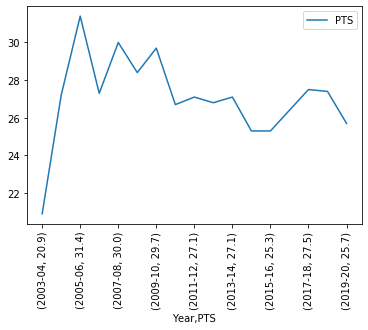

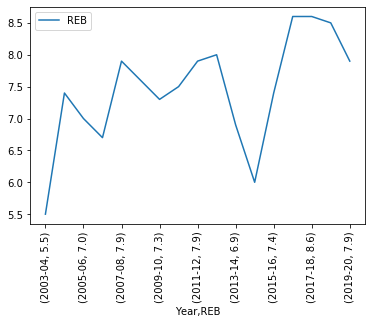

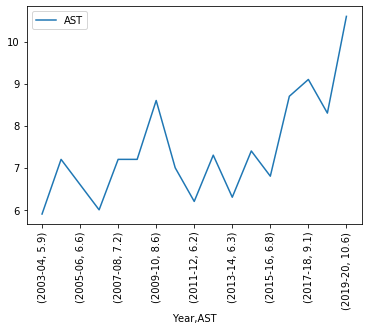

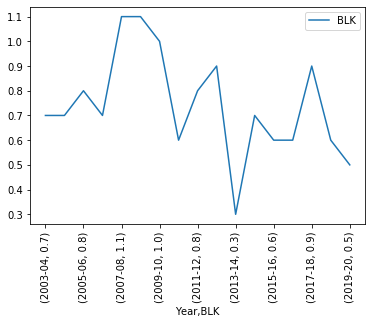

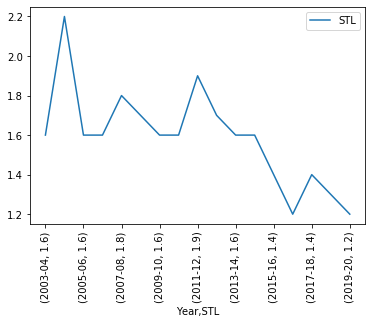

In [168]:
#%matplotlib inline
#
pts.plot(use_index= 1, rot=90)
reb.plot(use_index= 1, rot=90)
ast.plot(use_index= 1, rot=90)
blk.plot(use_index= 1, rot=90)
stl.plot(use_index= 1, rot=90)
plt.savefig(r'output/pts.png')

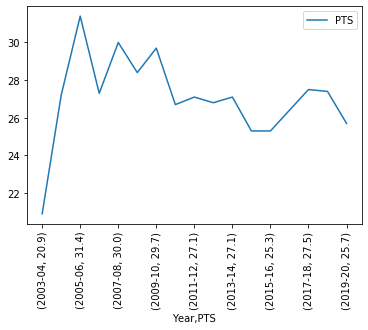

In [167]:
pts.plot(use_index= 1, rot=90)


In [136]:
# Initialize a new figure
fig, ax = plt.subplots()

# Draw the graph
ax = ax.plot(df['GDP_per_capita'], df['life_expectancy'], linestyle='', marker='o')

# Set the label for the x-axis
ax.set_xlabel("GDP (per capita)")

# Set the label for the y-axis
ax.set_ylabel("Life expectancy at birth")

NameError: name 'ax' is not defined

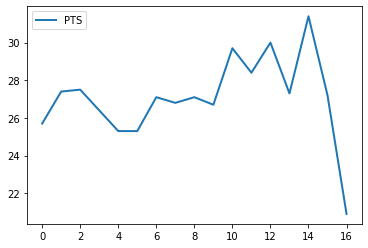

In [57]:
#%matplotlib inline
display(table_player1[['Year', 'PTS']].plot(linewidth=2, markersize=12))

In [41]:
table_player1_2 = table_player1.groupby(['Year'])

In [42]:
display(table_player1_2)